## GWO & Hail Environment Relationship
##### Dr. Victor Gensini (Fall 2017)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
import datetime, os, calendar
import numpy as np
import pandas as pd
from netCDF4 import date2num,date2index
from netCDF4 import Dataset
from IPython.display import Image
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
import scipy.stats
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.stats.mstats import linregress
from scipy import stats
import shapefile
import seaborn as sns

### GWO data

In [2]:
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()
phase_st_anoms = np.empty((0,277,349))
probs_scp = np.empty((0,277,349))

phase_td_anoms = np.empty((0,277,349))
probs_td = np.empty((0,277,349))

nc = Dataset('/home/data/bwd500hgtdewp/controls_1979_2016.nc','r',format='NETCDF4_CLASSIC')
mean_scp_daily = np.load('/home/data/bwd500hgtdewp/narr_doy_hght500mb_1979_2016.npy')
mean_td_daily = np.load('/home/data/bwd500hgtdewp/narr_doy_dewp2m_1979_2016.npy')

In [3]:
gwo_file = 'gwo.csv'
gwo_df = pd.read_csv(gwo_file)
formats = '%Y-%m-%d'
gwo_df['date']=pd.to_datetime(gwo_df['date'], format=formats)
gwo_df=gwo_df.set_index(pd.DatetimeIndex(gwo_df['date']))
hail_file = '1955-2016_hail.csv'
hail_df = pd.read_csv(hail_file)
hail_df['datei']=pd.to_datetime(hail_df['date'], format=formats)
hail_df=hail_df.set_index(pd.DatetimeIndex(hail_df['datei']))
sevhail_df = hail_df[hail_df.mag>=1]
sighail_df = hail_df[hail_df.mag>=2]
gianthail_df = hail_df[hail_df.mag>=4]
amp=1
phases=[1.5,2.5,3.5,4.5,5.5,6.5,7.5,0.5]
#months=np.arange(1,13,1)
months=[6]
phasetxt=[1,2,3,4,5,6,7,8]
phaseltr=['a)','b)','c)','d)','e)','f)','g)','h)']
temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
cmap = matplotlib.colors.ListedColormap(temper_anom)

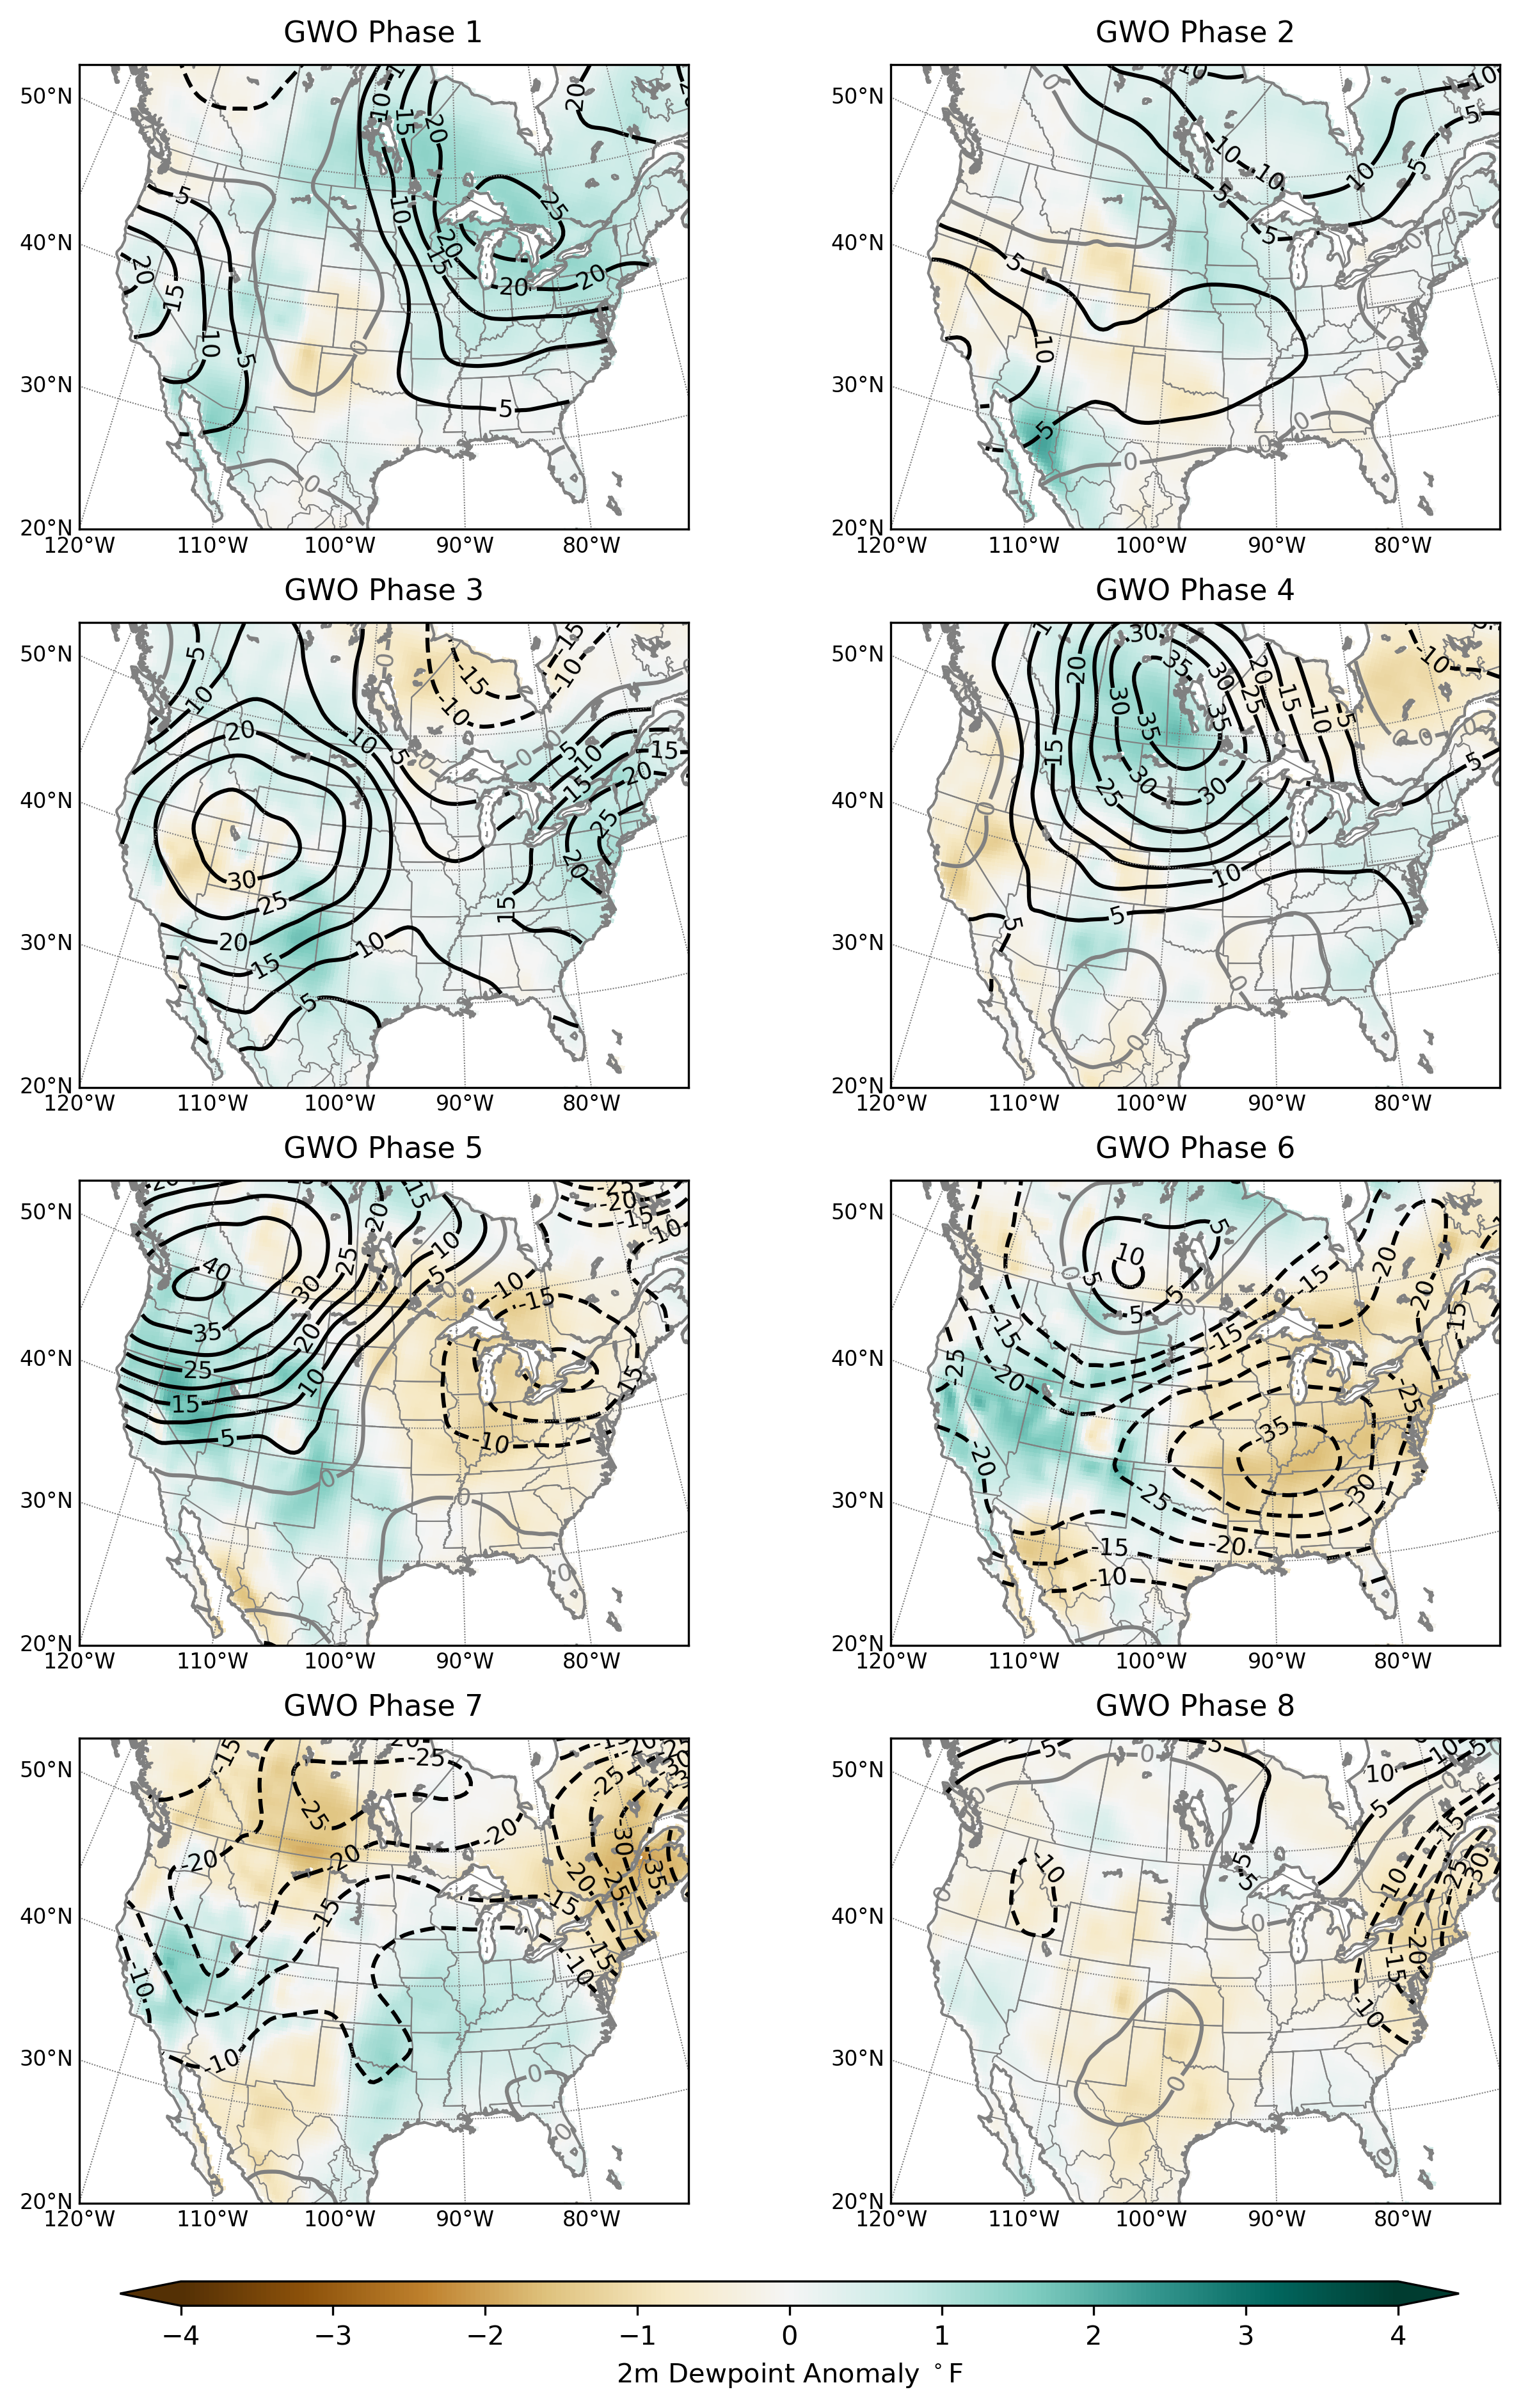

In [4]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,18),dpi=300)
# = Basemap  (projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=20, urcrnrlat=55,llcrnrlon=-120,urcrnrlon=-60,resolution='l',area_thresh=1000)
#,y = m(lons,lats)

for ax in axes.flat:
    m = Basemap  (projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=20, urcrnrlat=55,llcrnrlon=-120,urcrnrlon=-60,resolution='l',area_thresh=1000,ax=ax)
    x,y = m(lons,lats)
    m.drawcoastlines(color='gray')
    m.drawstates(color='gray')
    m.drawcountries(color='gray')
    parallels = np.arange(0.,90,10.)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,color='grey',linewidth=0.5)
    meridians = np.arange(180.,360.,10.)
    m.drawmeridians(meridians,labels=[0,0,0,2],fontsize=8,color='grey',linewidth=0.5)

for month in months:
    for i,phase in enumerate(phases):
        query='amp>=%s & phase==%s & year>=1979 & year<=2016 & month==%s' % (amp,phase,month)
        phase_amp_df = gwo_df.query(query)      
        #query='hr>=13 & hr<=18'
        #sig_hail_df=sighail_df.query(query)
        sig_hail_df=sighail_df.loc[sighail_df['datei'].isin(phase_amp_df['date'])]
        hail_lats = sig_hail_df['slat']
        hail_lons = sig_hail_df['slon']
        for dt in phase_amp_df['date']+datetime.timedelta(hours=21):
            if calendar.isleap(dt.year)==True:
                tt=dt.timetuple().tm_yday-2
            else:
                tt=dt.timetuple().tm_yday-1
            day_mean_scp=mean_scp_daily[tt][:][:]
            day_mean_dewp2m=mean_td_daily[tt][:][:]
            #day_mean_scp_log=mean_scp_daily_log[tt][:][:]
            #day_stdev_scp=stdev_scp_daily[tt][:][:]
            #day_stdev_scp_log=stdev_scp_daily_log[tt][:][:] 
            idex = date2index(dt,nc['time'])
            scp = nc.variables["hght500mb"][idex][:][:]
            td = nc.variables["dewp2m"][idex][:][:]
            #cin  = nc.variables["sbcin"][idex][:][:]
            #cin mask
            #term5 = np.fabs(cin)
            #term5[np.fabs(cin)>50]=0.
            #term5[np.fabs(cin)<=50]=1.
            #scp = scp * term5
            #scp[scp<1]=0.
            #scp[scp>=1]=1.
            #anom = scp-day_mean_scp
            #st_anom = anom/day_stdev_scp
            phase_st_anoms = np.append(phase_st_anoms,[scp],axis=0)
            probs_scp = np.append(probs_scp,[day_mean_scp],axis=0)
            phase_td_anoms = np.append(phase_td_anoms,[td],axis=0)
            probs_td = np.append(probs_td,[day_mean_dewp2m],axis=0)
        mean_ph1 = np.mean(phase_st_anoms,axis=0)
        mean_probs = np.mean(probs_scp,axis=0)
        prob_anom = mean_ph1-mean_probs
        mean_td = np.mean(phase_td_anoms,axis=0)
        mean_td_probs = np.mean(probs_td,axis=0)
        prob_td_anom = mean_td-mean_td_probs
        #mean_ph1 = np.mean(phase_st_anoms,axis=0)
        #Guassian smooth probs
        phase_st_anoms = np.empty((0,277,349))
        probs_scp = np.empty((0,277,349))
        phase_td_anoms = np.empty((0,277,349))
        probs_td = np.empty((0,277,349))
        sigma = 1
        mean_ph1 = scipy.ndimage.filters.gaussian_filter(prob_anom,sigma,order=0)
        mean_ph2 = scipy.ndimage.filters.gaussian_filter(prob_td_anom,sigma,order=0)
        
        masked = maskoceans(lons,lats,mean_ph1)
        masked1 = maskoceans(lons,lats,mean_ph2)

        #plot = m.pcolormesh(x,y,masked,zorder=1, norm=colors.LogNorm(vmin=1, vmax=50),cmap=cm.magma)
        track = axes.flat[i].pcolormesh(x,y,masked1,zorder=1,vmin=-4, vmax=4,cmap=cm.BrBG)
        CL1=axes.flat[i].contour(x,y,masked,colors='black',levels=[np.arange(5,100,5)],linestyles='solid')
        CL2=axes.flat[i].contour(x,y,masked,colors='grey',levels=[0],linestyles='solid')
        CL3=axes.flat[i].contour(x,y,masked,colors='black',levels=[np.arange(-100,-5,5)],linestyles='dashed')
        fmt='%.0f'
        axes.flat[i].clabel(CL1, fontsize=9, inline=1, fmt=fmt)
        axes.flat[i].clabel(CL2, fontsize=9, inline=1, fmt=fmt)
        axes.flat[i].clabel(CL3, fontsize=9, inline=1, fmt=fmt)
        axes.flat[i].annotate('GWO Phase '+str(i+1),(.5,1.05), xycoords='axes fraction', ha='center', fontsize=11)
        
        #colbar.set_label('1979-2016 Slope of STP Hours > 1',fontsize='medium',weight='bold')
        #plt.savefig(str(month)+'_'+str(phasetxt[i])+'.png')
cbar = fig.colorbar(track,ax=axes.ravel().tolist(),ticks=[-4,-3,-2,-1,0,1,2,3,4], orientation='horizontal', pad=.03,aspect=50, shrink=.9, extend='both')
cbar.set_label('2m Dewpoint Anomaly ' +r'$^\circ$F' )
plt.savefig('June.png') 